# Opioid Addiction Project
## Notebook 05: Feature Importance

This notebook focuses on calculating feature importance

1. Load trained models from disk
2. Generate feature importance (Shapley values) ...
  * For the overall model
  * For individual predictions, including re-aggregating one-hot encoded values.

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
from collections import defaultdict
import operator

#Feature Importance
import shap #conda install -c conda-forge shap
shap.initjs()  #Javascript for Shapley Values

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 200
dataDir = './data/'

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 1. Load Data

This step loads the models and data.

In [2]:
#Load Models
modelXGB = joblib.load(dataDir+'modelXGB.model')
calibratorXGB = joblib.load(dataDir+'calibXGB.model')

#Load data used for feature importance
valX = pd.read_pickle(dataDir+'valX.pickle.zip')
testX = pd.read_pickle(dataDir+'testX.pickle.zip')

print(type(modelXGB))
print(type(calibratorXGB))
print(type(valX))
print(type(testX))

<class 'xgboost.sklearn.XGBClassifier'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# 2. Feature Importance

This section calculates feature importance for the models, split into two items:

1. Calculate overall feature importance for the model. This will be useful for understanding the model as a whole, and in that sense is akin to EDA, but for the model rather than the raw data.
2. Calculate feature importance for an individual example. This is what will be used when giving individual respondents their score.

As part of these tasks, we will also incorporate aggregating feature importance scores from one-hot encoded features.

In [3]:
#Make a single prediction
for row in range(0,50):
    predM = modelXGB.predict_proba(testX.iloc[[row]])[0][1] #ARGH! Need double brackets for XGBoost model to predict
    predC = calibratorXGB.predict_proba(np.array(testX.iloc[row]).reshape(1, -1))[0][1]
    
    print('Case {}: UNCALIBRATED Prediction: {:.2%}'.format(row, predM))
    print('Case {}:   CALIBRATED Prediction: {:.2%}\n'.format(row, predC))       

Case 0: UNCALIBRATED Prediction: 45.42%
Case 0:   CALIBRATED Prediction: 16.64%

Case 1: UNCALIBRATED Prediction: 51.78%
Case 1:   CALIBRATED Prediction: 17.92%

Case 2: UNCALIBRATED Prediction: 19.57%
Case 2:   CALIBRATED Prediction: 8.00%

Case 3: UNCALIBRATED Prediction: 24.80%
Case 3:   CALIBRATED Prediction: 8.53%

Case 4: UNCALIBRATED Prediction: 33.66%
Case 4:   CALIBRATED Prediction: 8.62%

Case 5: UNCALIBRATED Prediction: 30.02%
Case 5:   CALIBRATED Prediction: 8.18%

Case 6: UNCALIBRATED Prediction: 29.94%
Case 6:   CALIBRATED Prediction: 8.54%

Case 7: UNCALIBRATED Prediction: 58.51%
Case 7:   CALIBRATED Prediction: 37.04%

Case 8: UNCALIBRATED Prediction: 37.22%
Case 8:   CALIBRATED Prediction: 9.11%

Case 9: UNCALIBRATED Prediction: 30.89%
Case 9:   CALIBRATED Prediction: 11.77%

Case 10: UNCALIBRATED Prediction: 24.12%
Case 10:   CALIBRATED Prediction: 8.58%

Case 11: UNCALIBRATED Prediction: 38.35%
Case 11:   CALIBRATED Prediction: 9.22%

Case 12: UNCALIBRATED Prediction

In [4]:
#CK: Plot calibrated vs. uncalibreated, color on actual prediction.

In [5]:
#Calculate Shapley Values
#NOTE: Currently this takes a couple minutes to run

explainer = shap.TreeExplainer(modelXGB, valX, feature_dependence='independent', model_output='probability')
#Note, very specifically this is where we need XGBoost 0.81 (0.80 failed, and 0.90 killed the kernel).

#This helped at one point: https://evgenypogorelov.com/multiclass-xgb-shap.html

In [6]:
#Save the explainer (for use in the web app)
joblib.dump(explainer, dataDir+'modelXGB.explainer')

['./data/modelXGB.explainer']

 95%|=================== | 95/100 [00:19<00:01]       

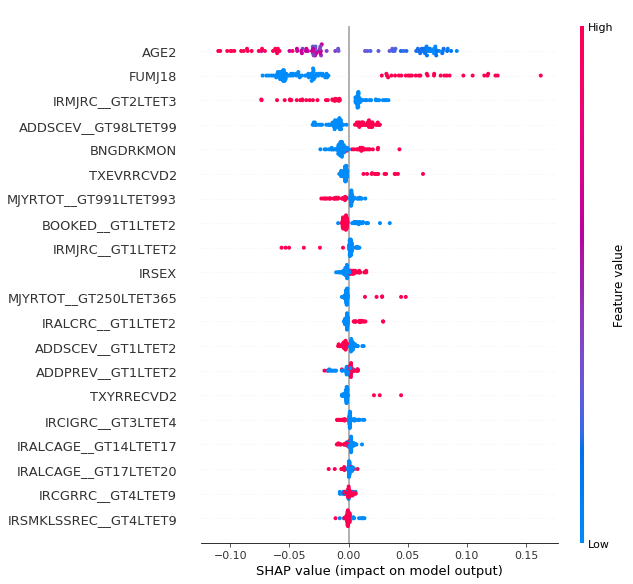

In [7]:
#Overall model inspection
valXSample = valX.sample(100)
shap_values = explainer.shap_values(valXSample)
shap.summary_plot(shap_values, valXSample)

## Individual Predictions

Now that we have our overall model, we can build predictions at the individual level.

It's important that from here forward, we generate a new shapley value for each individual prediction (don't use the values from the sample).

In [8]:
#Make an individual prediction on test data

#Get a random row from our test data
randTestRow = testX.sample(1)

#Make the prediction from the model(s)
predM = modelXGB.predict_proba(randTestRow)[0][1]
predC = calibratorXGB.predict_proba(randTestRow)[0][1]
print('UNCALIBRATED Prediction: {:.2%}'.format(predM))
print('  CALIBRATED Prediction: {:.2%}\n'.format(predC))       

#Generate shapley values from this row
shapVal = explainer.shap_values(randTestRow)

#Plot shapley values
shap.force_plot(explainer.expected_value, shapVal, randTestRow)

UNCALIBRATED Prediction: 28.92%
  CALIBRATED Prediction: 8.43%



In the cell above, notice the prediction in the plot matches the uncalibrated prediction from the model.

In [9]:
randTestRow

,ADDPREV__GT1LTET2,ADDPREV__GT2LTET85,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDPREV__GT97LTET98,ADDPREV__GT98LTET99,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BNGDRKMON,BOOKED__GT1LTET2,BOOKED__GT2LTET3,BOOKED__GT3LTET85,BOOKED__GT85LTET94,BOOKED__GT94LTET97,BOOKED__GT97LTET98,CIGAGE__GT10LTET13,CIGAGE__GT13LTET15,CIGAGE__GT15LTET17,CIGAGE__GT17LTET18,CIGAGE__GT18LTET19,CIGAGE__GT19LTET20,CIGAGE__GT20LTET22,CIGAGE__GT22LTET25,CIGAGE__GT25LTET30,CIGAGE__GT30LTET40,CIGAGE__GT40LTET50,CIGAGE__GT50LTET99,CIGAGE__GT985LTET991,CIGAGE__GT991LTET994,CIGAGE__GT994LTET997,CIGAGE__GT997LTET998,CIGAGE__GT998LTET999,CIGAGE__GT99LTET985,CIGDLYMO__GT1LTET2,CIGDLYMO__GT2LTET5,CIGDLYMO__GT5LTET91,CIGDLYMO__GT91LTET94,CIGDLYMO__GT94LTET97,EDUHIGHCAT__GT1LTET2,EDUHIGHCAT__GT2LTET3,EDUHIGHCAT__GT3LTET4,EDUHIGHCAT__GT4LTET5,FUMJ18,FUMJ21,HVYDRKMON,IRALCAGE__GT100LTET991,IRALCAGE__GT14LTET17,IRALCAGE__GT17LTET20,IRALCAGE__GT20LTET21,IRALCAGE__GT21LTET100,IRALCFY__GT11LTET49,IRALCFY__GT299LTET365,IRALCFY__GT365LTET993,IRALCFY__GT49LTET99,IRALCFY__GT99LTET299,IRALCRC__GT1LTET2,IRALCRC__GT2LTET3,IRALCRC__GT3LTET9,IRCGRRC__GT1LTET2,IRCGRRC__GT2LTET3,IRCGRRC__GT3LTET4,IRCGRRC__GT4LTET9,IRCIGRC__GT1LTET2,IRCIGRC__GT2LTET3,IRCIGRC__GT3LTET4,IRCIGRC__GT4LTET9,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,IRSMKLSSREC__GT1LTET2,IRSMKLSSREC__GT2LTET3,IRSMKLSSREC__GT3LTET4,IRSMKLSSREC__GT4LTET9,MJYRTOT__GT100LTET150,MJYRTOT__GT10LTET20,MJYRTOT__GT150LTET200,MJYRTOT__GT1LTET2,MJYRTOT__GT200LTET250,MJYRTOT__GT20LTET30,MJYRTOT__GT250LTET365,MJYRTOT__GT2LTET3,MJYRTOT__GT30LTET40,MJYRTOT__GT365LTET985,MJYRTOT__GT3LTET7,MJYRTOT__GT40LTET50,MJYRTOT__GT50LTET100,MJYRTOT__GT7LTET10,MJYRTOT__GT985LTET991,MJYRTOT__GT991LTET993,MJYRTOT__GT993LTET994,MJYRTOT__GT994LTET997,MJYRTOT__GT997LTET998,PIPEVER__GT1LTET2,PIPEVER__GT2LTET94,PIPEVER__GT94LTET97,TXEVRRCVD2,TXYRRECVD2
2790,0,0,0,0,0,0,0,0,0,0,1,0.462087,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [10]:
explainer.expected_value #This represents the AVERAGE (not the median) value

0.36550401821035616

In [11]:
#Aggregate shapley values for one-hot vectors

shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

#Get everything before the '_' character of each column name
#Then create the column index numbers for those keys 
#These numbers correspond to the locations in the shapley output array
for i, colName in enumerate(randTestRow.columns):
    shapDict[colName.split('_')[0]].append(i)
    
#Make a list of aggregated values shapley
print(shapDict)
print()
for k in shapDict: #Loop through every key in the dict
    shapSum = 0.0 #Reset to 0
    for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
        shapSum += shapVal[0][index] #Add the value for each item
    shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)
    
print(shapDict)

defaultdict(<class 'list'>, {'ADDPREV': [0, 1, 2, 3, 4, 5], 'ADDSCEV': [6, 7, 8, 9, 10], 'AGE2': [11], 'BNGDRKMON': [12], 'BOOKED': [13, 14, 15, 16, 17, 18], 'CIGAGE': [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], 'CIGDLYMO': [37, 38, 39, 40, 41], 'EDUHIGHCAT': [42, 43, 44, 45], 'FUMJ18': [46], 'FUMJ21': [47], 'HVYDRKMON': [48], 'IRALCAGE': [49, 50, 51, 52, 53], 'IRALCFY': [54, 55, 56, 57, 58], 'IRALCRC': [59, 60, 61], 'IRCGRRC': [62, 63, 64, 65], 'IRCIGRC': [66, 67, 68, 69], 'IRMJRC': [70, 71, 72], 'IRSEX': [73], 'IRSMKLSSREC': [74, 75, 76, 77], 'MJYRTOT': [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], 'PIPEVER': [97, 98, 99], 'TXEVRRCVD2': [100], 'TXYRRECVD2': [101]})

defaultdict(<class 'list'>, {'ADDPREV': -0.0162058255273115, 'ADDSCEV': 0.023702823370860923, 'AGE2': -0.029368824725169843, 'BNGDRKMON': -0.006650555040852016, 'BOOKED': -0.0019546606339033703, 'CIGAGE': 0.00020572389577549143, 'CIGDLYMO': -3.314820703741493e-

## Summary

So for output, we need:

1. User's prediction, __%
2. Percentile (later, need distribution first, not hard)
3. +/-__._% (just print for now)



In [12]:
#Print Summary Results

#Get a random row from our test data
randTestRow = testX.sample(1)

#Make the prediction from the model(s)
predM = modelXGB.predict_proba(randTestRow)[0][1]
print('Prediction: {:.0%}'.format(predM))

#Generate shapley values from this row
shapVal = explainer.shap_values(randTestRow)

#Aggregate shapley values for one-hot vectors
shapDict = defaultdict(list) #Handy: creates blank list if key doesn't exist, or appends to it if it does.

#Get everything before the '_' character of each column name
#Then create the column index numbers for those keys 
#These numbers correspond to the locations in the shapley output array
for i, colName in enumerate(randTestRow.columns):
    shapDict[colName.split('_')[0]].append(i)
    
#Make a list of aggregated values shapley
for k in shapDict: #Loop through every key in the dict
    shapSum = 0.0 #Reset to 0
    for index in shapDict[k]: #Loop through every item in the key's value (a list of column indexes)
        shapSum += shapVal[0][index] #Add the value for each item
    shapDict[k] = shapSum #Replace the list with the aggregated shapley value (the sum of each individual value)

sortedShapDict = dict(sorted(shapDict.items(), key=operator.itemgetter(1)))
print('Feature Importance:')
sortedShapDict

Prediction: 55%
Feature Importance:


{'IRMJRC': -0.01631726659095154,
 'BNGDRKMON': -0.00755227630975244,
 'IRSMKLSSREC': -0.00380543121273238,
 'TXYRRECVD2': -0.00333492435350565,
 'IRCGRRC': -0.0032365404939878,
 'BOOKED': -0.002675240908616026,
 'TXEVRRCVD2': -0.0022768226486728363,
 'EDUHIGHCAT': -0.0012532672501769312,
 'HVYDRKMON': -0.000849891186109413,
 'CIGAGE': -0.0006431037985593862,
 'PIPEVER': -0.0006354201200347687,
 'IRALCFY': 0.0001373504234654822,
 'FUMJ21': 0.0004487030263962054,
 'ADDPREV': 0.0007293016322097392,
 'IRSEX': 0.0015869266268474659,
 'CIGDLYMO': 0.0018269157125198226,
 'MJYRTOT': 0.007666964479219204,
 'IRALCAGE': 0.008657518213326242,
 'IRCIGRC': 0.009749735006392837,
 'ADDSCEV': 0.021380995470696027,
 'IRALCRC': 0.02916445204743446,
 'AGE2': 0.06795914584612213,
 'FUMJ18': 0.08093154078406163}

In [13]:
randTestRow

,ADDPREV__GT1LTET2,ADDPREV__GT2LTET85,ADDPREV__GT85LTET94,ADDPREV__GT94LTET97,ADDPREV__GT97LTET98,ADDPREV__GT98LTET99,ADDSCEV__GT1LTET2,ADDSCEV__GT2LTET94,ADDSCEV__GT94LTET97,ADDSCEV__GT97LTET98,ADDSCEV__GT98LTET99,AGE2,BNGDRKMON,BOOKED__GT1LTET2,BOOKED__GT2LTET3,BOOKED__GT3LTET85,BOOKED__GT85LTET94,BOOKED__GT94LTET97,BOOKED__GT97LTET98,CIGAGE__GT10LTET13,CIGAGE__GT13LTET15,CIGAGE__GT15LTET17,CIGAGE__GT17LTET18,CIGAGE__GT18LTET19,CIGAGE__GT19LTET20,CIGAGE__GT20LTET22,CIGAGE__GT22LTET25,CIGAGE__GT25LTET30,CIGAGE__GT30LTET40,CIGAGE__GT40LTET50,CIGAGE__GT50LTET99,CIGAGE__GT985LTET991,CIGAGE__GT991LTET994,CIGAGE__GT994LTET997,CIGAGE__GT997LTET998,CIGAGE__GT998LTET999,CIGAGE__GT99LTET985,CIGDLYMO__GT1LTET2,CIGDLYMO__GT2LTET5,CIGDLYMO__GT5LTET91,CIGDLYMO__GT91LTET94,CIGDLYMO__GT94LTET97,EDUHIGHCAT__GT1LTET2,EDUHIGHCAT__GT2LTET3,EDUHIGHCAT__GT3LTET4,EDUHIGHCAT__GT4LTET5,FUMJ18,FUMJ21,HVYDRKMON,IRALCAGE__GT100LTET991,IRALCAGE__GT14LTET17,IRALCAGE__GT17LTET20,IRALCAGE__GT20LTET21,IRALCAGE__GT21LTET100,IRALCFY__GT11LTET49,IRALCFY__GT299LTET365,IRALCFY__GT365LTET993,IRALCFY__GT49LTET99,IRALCFY__GT99LTET299,IRALCRC__GT1LTET2,IRALCRC__GT2LTET3,IRALCRC__GT3LTET9,IRCGRRC__GT1LTET2,IRCGRRC__GT2LTET3,IRCGRRC__GT3LTET4,IRCGRRC__GT4LTET9,IRCIGRC__GT1LTET2,IRCIGRC__GT2LTET3,IRCIGRC__GT3LTET4,IRCIGRC__GT4LTET9,IRMJRC__GT1LTET2,IRMJRC__GT2LTET3,IRMJRC__GT3LTET9,IRSEX,IRSMKLSSREC__GT1LTET2,IRSMKLSSREC__GT2LTET3,IRSMKLSSREC__GT3LTET4,IRSMKLSSREC__GT4LTET9,MJYRTOT__GT100LTET150,MJYRTOT__GT10LTET20,MJYRTOT__GT150LTET200,MJYRTOT__GT1LTET2,MJYRTOT__GT200LTET250,MJYRTOT__GT20LTET30,MJYRTOT__GT250LTET365,MJYRTOT__GT2LTET3,MJYRTOT__GT30LTET40,MJYRTOT__GT365LTET985,MJYRTOT__GT3LTET7,MJYRTOT__GT40LTET50,MJYRTOT__GT50LTET100,MJYRTOT__GT7LTET10,MJYRTOT__GT985LTET991,MJYRTOT__GT991LTET993,MJYRTOT__GT993LTET994,MJYRTOT__GT994LTET997,MJYRTOT__GT997LTET998,PIPEVER__GT1LTET2,PIPEVER__GT2LTET94,PIPEVER__GT94LTET97,TXEVRRCVD2,TXYRRECVD2
40834,0,0,0,0,0,0,0,0,0,0,1,-0.730225,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [14]:
#SAMPLE
print("Prediction: 39%\nFeature Importance:\n {'MJYRTOT': -0.033759850148928974, 'IRALCAGE': -0.024682580463537853, 'ADDPREV': -0.01880616937997499, 'BOOKED': -0.007883026482571978, 'TXEVRRCVD2': -0.005300225709202507, 'TXYRRECVD2': -0.004804847595162599, 'IREDUHIGHST2': -0.004201756510575546, 'PIPEVER': -0.0033173092403240415, 'IRALCRC': -0.0029041743401314784, 'CIGDLYMO': -0.0018836703784005852, 'FUMJ21': 0.002012582602908529, 'CIGAGE': 0.0020705857818002276, 'IRCGRRC': 0.0041072546969989215, 'IRCIGRC': 0.006616356965433702, 'IRSEX': 0.008320252113440063, 'HVYDRKMON': 0.01041202285340691, 'ADDSCEV': 0.012017856386278907, 'BNGDRKMON': 0.03547992224927512, 'IRMJRC': 0.035671748433736286, 'IRALCFY': 0.04375034076697532, 'IRSMKLSSREC': 0.048125046918270416, 'AGE2': 0.059831055332146284, 'FUMJ18': 0.06594032294877213}")

Prediction: 39%
Feature Importance:
 {'MJYRTOT': -0.033759850148928974, 'IRALCAGE': -0.024682580463537853, 'ADDPREV': -0.01880616937997499, 'BOOKED': -0.007883026482571978, 'TXEVRRCVD2': -0.005300225709202507, 'TXYRRECVD2': -0.004804847595162599, 'IREDUHIGHST2': -0.004201756510575546, 'PIPEVER': -0.0033173092403240415, 'IRALCRC': -0.0029041743401314784, 'CIGDLYMO': -0.0018836703784005852, 'FUMJ21': 0.002012582602908529, 'CIGAGE': 0.0020705857818002276, 'IRCGRRC': 0.0041072546969989215, 'IRCIGRC': 0.006616356965433702, 'IRSEX': 0.008320252113440063, 'HVYDRKMON': 0.01041202285340691, 'ADDSCEV': 0.012017856386278907, 'BNGDRKMON': 0.03547992224927512, 'IRMJRC': 0.035671748433736286, 'IRALCFY': 0.04375034076697532, 'IRSMKLSSREC': 0.048125046918270416, 'AGE2': 0.059831055332146284, 'FUMJ18': 0.06594032294877213}


Joe User's Report:

YOUR LIKELIHOOD OF MISUSE: 39%

YOUR PERCENTILE: 95%

TOP FACTORS CONTRIBUTING TO THIS SCORE:

_(imagine these bullets as a bar chart)_

* Weed < 18 = Yes: +6.6%
* Age = 17: +5.9%
* IRSM... = X: +4.8%
* ...


In [15]:
sum(shapVal[0])

0.18765936439559203

# CK: Next step, let's simulate real responses, run them through the preprocessing

# Doodling. Lots of this stuff works but need to gather it and then delete

In [16]:
sum(shap_values[3])

-0.04612002572565482

In [17]:
ev = explainer.expected_value
ev

0.36550401821035616

In [18]:
'''WARNING BE REALLY CAREFUL AS YOU'RE CURRENTLY MIXING VALIDATION, THE FULL TEST DATA, 
AND A SAMPLE OF THE TEST DATA. DON'T FORGET TO RECTIFY THIS!!!
'''

"WARNING BE REALLY CAREFUL AS YOU'RE CURRENTLY MIXING VALIDATION, THE FULL TEST DATA, \nAND A SAMPLE OF THE TEST DATA. DON'T FORGET TO RECTIFY THIS!!!\n"

In [19]:
shap.force_plot(explainer.expected_value, shap_values[3,:], testX.iloc[3,:])

In [23]:
#Get a single shap value
row = 0
shapVal = explainer.shap_values(valX.iloc[row]) #This is how much it changes from the expected value baseline
#AND IT APPEARS TO BE ADDITIVE!!!
sum(shapVal)

-0.1473016092356832

In [21]:
#AT SOME POINT WE SHOULD CHECK TO ENSURE THAT NO PREDICTIONS ARE <0% OR >100%

# Tasks

* Can't make predicitons from uncalibrated model, seemingly because the column order is being shuffled at some point. Need to fix.
* Shap does not support calibrated models ... need to solve. But there might be an empirical method.